<a href="https://colab.research.google.com/github/AvantiShri/gcp_analysis/blob/main/gcp1reanalysis/GCP1_Data_Reanalysis_LifetimeNormalize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Preparation

In [1]:
#mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/GCP_data/all_data
#data at https://drive.google.com/drive/u/0/folders/1MUS-xbwoBiodWLz4gese19ti_ftlKsVu

/content/drive/MyDrive/GCP_data/all_data


In [3]:
#install utilities code for reading/parsing data at https://github.com/AvantiShri/gcpdatautils
!pip uninstall -y gcpdatautils #uninstall the pre-existing version if want to fetch latest
!pip install git+https://github.com/AvantiShri/gcpdatautils.git@main #install latest from github

#Note: the code that was used to consolidate the downloaded csv.gz files into hdf5 files
# is at https://github.com/AvantiShri/gcp_analysis/blob/main/alldata/Consolidate_GCP_as_HDF5.ipynb

  Cloning https://github.com/AvantiShri/gcpdatautils.git (to revision main) to /tmp/pip-req-build-zjf0u0o_
  Running command git clone --filter=blob:none --quiet https://github.com/AvantiShri/gcpdatautils.git /tmp/pip-req-build-zjf0u0o_
  Resolved https://github.com/AvantiShri/gcpdatautils.git to commit 55a9bc16c7c36ea920eafb44079d401f76da48f1
  Preparing metadata (setup.py) ... done
  Created wheel for gcpdatautils: filename=gcpdatautils-0.1.1.3-py3-none-any.whl size=6405 sha256=ab9499a417b0e4a101fbe73e39ea1da2effc9b496a24209c012af73dbb8adc1a
  Stored in directory: /tmp/pip-ephem-wheel-cache-c400eegh/wheels/8c/35/d9/946037b24577e21d0dce0d66645d002768f5bac3497186d55f
Successfully built gcpdatautils


Load in the GCP event timeperiod definitions

In [4]:
from gcpdatautils import parse_events_html

#download the formal event registry if not already present
!wget https://global-mind.org/pred_formal.html -O pred_formal.html

# we will parse the events file, dropping events longer than 30 days for memory efficiency
# we will also drop 'New Year Var...' events as they tend to be redundant in duration
# with the 'mean' events, and we are going to do a standard analysis on all the events
included_events = parse_events_html("/content/drive/MyDrive/GCP_data/pred_formal.html",
                                    exclude_events_longer_than_days=30)

--2024-02-13 20:05:16--  https://global-mind.org/pred_formal.html
Resolving global-mind.org (global-mind.org)... 162.245.217.130
Connecting to global-mind.org (global-mind.org)|162.245.217.130|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘pred_formal.html’

pred_formal.html        [  <=>               ] 184.64K   378KB/s    in 0.5s    

2024-02-13 20:05:17 (378 KB/s) - ‘pred_formal.html’ saved [189067]

Skipping because redundant with a corresponding 'mean' event:  43 New Year Var 99-00 1999-12-31 09:30:00 2000-01-01 11:29:59
Skipping because redundant with a corresponding 'mean' event:  65 New Year Var 00-01 2000-12-31 09:30:00 2001-01-01 11:29:59
Skipping because end < start: 82 Silent Prayer, Sept 14 2001-09-14 10:00:00 2001-09-14 10:00:00
Skipping because redundant with a corresponding 'mean' event:  98 New Year Var 01-02 2001-12-31 09:30:00 2002-01-01 11:29:59
Skipping because redundant with a corresponding 'mean' eve

In [5]:
len(included_events)

480

Load the code for reading from the hdf5 files

In [6]:
import numpy as np
from collections import defaultdict
import h5py
from datetime import datetime, timedelta
from gcpdatautils import GCPHdf5DataReader, GCPMissingDataError

#Refer to the github repo https://github.com/AvantiShri/gcpdatautils for the
# code for reading from the hdf5 files
#Instantiate the hdf5 data reader
#it will auto-load a rotteneggs.txt file specifying bad data time periods (downloaded from https://global-mind.org/rotteneggs and saved in the package)
# this rotten egg file can be overridden by altering the arguments to the GCPHdf5DataReader
gcp_data_reader = GCPHdf5DataReader()

Parsing the bad data file: /usr/local/lib/python3.10/dist-packages/gcpdatautils/resources/rotteneggs.txt
manually correcting 47,2000-01-01 00:00:00,2001-06-31 23:59:59,2222
manually correcting 47,2008-04-25 00:00:00,2008-04-55 23:59:59,1092


Pull data for a specific event to compare to the GCP plots, as a sanity check

('289', 'Meditations Valentines Day', datetime.datetime(2009, 2, 14, 0, 0), datetime.datetime(2009, 2, 14, 23, 59, 59), 86400.0)


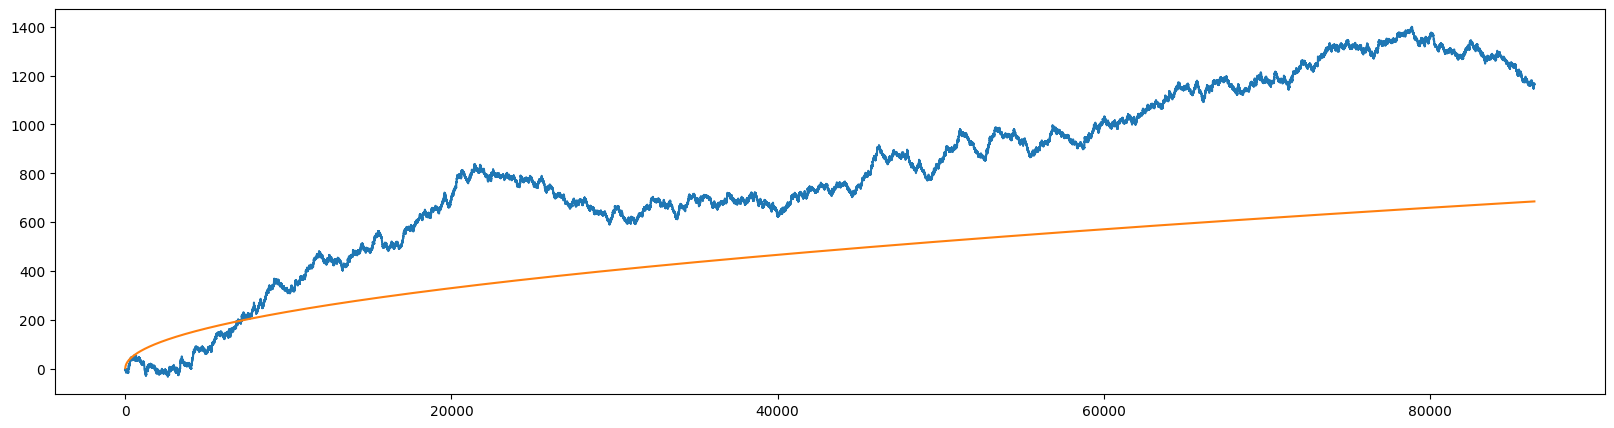

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import scipy
#data for a top-ranked GCP event - Valentine's day 2009
# Compare to: https://global-mind.org/valentines.09.html
idx=263
print(included_events[idx])

start_datetime, end_datetime = included_events[idx][2], included_events[idx][3]
event_data = gcp_data_reader.fetch_data(start_datetime, end_datetime, normalize=False)[0] #returns both the event data and the device ids; we just want the data

#make the chi-squared-minus-1 plot
csm1 = np.square(np.nansum((event_data - 100)/np.sqrt(50), axis=1)/np.sqrt(
        np.sum(np.isnan(event_data)==False, axis=1))) - 1
plt.figure(figsize=(20,5))
plt.plot(np.arange(len(csm1)), np.cumsum(csm1))
#also plot the p=0.05 envelop
plt.plot(np.arange(len(csm1)), np.array([scipy.stats.chi2.ppf(0.95, x+1)
                                         for x in np.arange(len(csm1))])
                                        - (np.arange(len(csm1))+1) )
plt.show()

Load the empirical variances, computed from https://github.com/AvantiShri/gcp_analysis/blob/main/alldata/ComputeLifetimeDeviceStats.ipynb

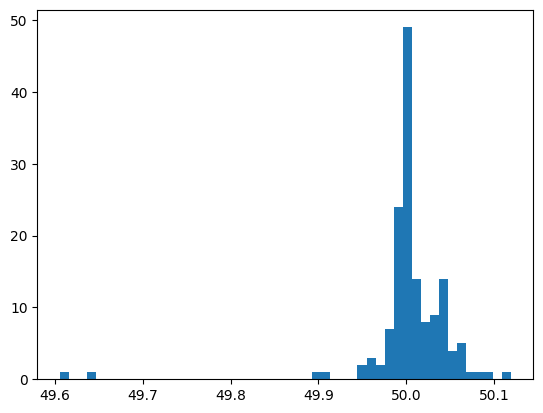

In [8]:
import json
from matplotlib import pyplot as plt

device_to_empirical_variances = json.loads(open("empirical_device_variances.json").read())
plt.hist(device_to_empirical_variances.values(), bins=50)
plt.show()

Do aggregate analysis

In [9]:
from datetime import datetime,timedelta
import numpy as np
import h5py
import traceback
import scipy


def normalize_by_lifetime_device_variance(data, devices, device_to_empirical_variances):
  data = np.array(data) #make a copy, just in case
  for i,device in enumerate(devices):
    scalefactor = (np.sqrt(device_to_empirical_variances[str(int(device))])/np.sqrt(50))
    data[:,i] = ((data[:,i]-100)/scalefactor)+100
  return data


def compute_pvaltoz(egg_values):

  num_nonnan_eggs = np.sum(np.isnan(egg_values)==False, axis=1) #get the number of non NaN eggs per row
  egg_zscores = (egg_values - 100)/np.sqrt(50)
  composite_z_scores = np.nansum(egg_zscores, axis=1)/np.sqrt(num_nonnan_eggs)

  print(np.nansum(np.square(composite_z_scores)))
  pvaltoz_sumthensquare = scipy.stats.norm.ppf(
      scipy.stats.chi2.cdf(x=np.nansum(np.square(composite_z_scores)),
                           df=np.sum(np.isnan(composite_z_scores)==False)))
  pvaltoz_squarethensum = scipy.stats.norm.ppf(
      scipy.stats.chi2.cdf(np.nansum(np.square(egg_zscores)),
                           df=np.sum(np.isnan(egg_zscores)==False)))

  return pvaltoz_sumthensquare, pvaltoz_squarethensum


def get_normalized_data(start_datetime, end_datetime, device_to_empirical_variances):
  data, devices = gcp_data_reader.fetch_data(start_datetime, end_datetime, normalize=DAY_NORMALIZE)
  if LIFETIME_NORMALIZE:
    data = normalize_by_lifetime_device_variance(data, devices, device_to_empirical_variances)
  return data


DAY_NORMALIZE = False
LIFETIME_NORMALIZE = True
assert (DAY_NORMALIZE and LIFETIME_NORMALIZE)==False #at most one should be true

control_timeshifts = [-2, 2] #how much to shift the events by (as a multiple of their duration) to define 'control' time periods

surviving_events = [] #in case we encounter missing data errors, maintain a list of surviving events

eventcount = 0

allevents_pvaltozs_sumthensquare = []
allevents_pvaltozs_squarethensum = []
controls_pvaltozs_sumthensquare = defaultdict(list)
controls_pvaltozs_squarethensum = defaultdict(list)

missing_data_errors = []

for (event_num, event_name, start_datetime, end_datetime, duration) in included_events[:]:
  eventcount += 1
  print("EVENT COUNT", eventcount)
  print(event_num, event_name, start_datetime, end_datetime, duration)
  try:
    event_data = get_normalized_data(start_datetime, end_datetime, device_to_empirical_variances)
    event_pvaltoz_sumthensquare, event_pvaltoz_squarethensum = compute_pvaltoz(event_data)
    print("Event data: Sum then square:", event_pvaltoz_sumthensquare)
    print("Event data: Square then sum:", event_pvaltoz_squarethensum)

    print("For controls...")
    thisevent_control_pvaltozs_sumthensquare = {}
    thisevent_control_pvaltozs_squarethensum = {}
    for control_timeshift in control_timeshifts:
      timeshift = timedelta(seconds=control_timeshift*duration)
      control_starttime = start_datetime + timeshift
      control_endtime = end_datetime + timeshift
      print("Control start and end:", control_starttime, control_endtime)
      control_data = get_normalized_data(control_starttime, control_endtime, device_to_empirical_variances)
      pvaltozs_sumthensquare, pvaltozs_squarethensum = compute_pvaltoz(control_data)
      print("Control data: Sum then square:", pvaltozs_sumthensquare)
      print("Control data: Square then sum:", pvaltozs_squarethensum)
      thisevent_control_pvaltozs_sumthensquare[control_timeshift] = pvaltozs_sumthensquare
      thisevent_control_pvaltozs_squarethensum[control_timeshift] = pvaltozs_squarethensum

    allevents_pvaltozs_sumthensquare.append(event_pvaltoz_sumthensquare)
    allevents_pvaltozs_squarethensum.append(event_pvaltoz_squarethensum)
    for control_timeshift in control_timeshifts:
      controls_pvaltozs_sumthensquare[control_timeshift].append(
          thisevent_control_pvaltozs_sumthensquare[control_timeshift])
      controls_pvaltozs_squarethensum[control_timeshift].append(
          thisevent_control_pvaltozs_squarethensum[control_timeshift])
    surviving_events.append((event_num, event_name, start_datetime, end_datetime, duration))
  except GCPMissingDataError as e:
    print("MISSING DATA ERROR!",e)
    missing_data_errors.append(e)


Streaming output truncated to the last 5000 lines.
28716.167043958725
Control data: Sum then square: -0.34686502908929984
Control data: Square then sum: -1.3646532574640997
Control start and end: 2003-12-26 17:30:00 2003-12-27 01:29:59
28922.98871633355
Control data: Sum then square: 0.5145021248877634
Control data: Square then sum: -1.2327431453459177
EVENT COUNT 143
161 60 Seconds for Peace 2003-12-27 21:00:00 2003-12-27 21:00:59 60.0
76.73024303008096
Event data: Sum then square: 1.4642978771868802
Event data: Square then sum: 0.3459290137102313
For controls...
Control start and end: 2003-12-27 20:58:00 2003-12-27 20:58:59
56.247826434351374
Control data: Sum then square: -0.288709066124998
Control data: Square then sum: 0.18831326655445607
Control start and end: 2003-12-27 21:02:00 2003-12-27 21:02:59
58.98861874326423
Control data: Sum then square: -0.031858236911567216
Control data: Square then sum: -0.020616935723644352
EVENT COUNT 144
162 New Year Mean 2003-2004 2003-12-31 09:3

num events after dropping events with missing data: 475
************TIME PERIODS: actual
Meta-analysis Z-score if squaring *after* summing: 5.712803749536643 pval: 5.556490600966413e-09
Meta-analysis Z-score if squaring *before* summing 1.3891521727195915 pval:  0.08239324083732802
Argmax event for square after summing: ('487', 'September 21', datetime.datetime(2014, 9, 21, 0, 0), datetime.datetime(2014, 9, 21, 23, 59, 59), 86400.0) 3.1593632636428017
Argmax event for square before summing: ('271', 'Obama Acceptance 080828', datetime.datetime(2008, 8, 29, 2, 0), datetime.datetime(2008, 8, 29, 3, 59, 59), 7200.0) 3.592093533886973
Correlation between the two scores: PearsonRResult(statistic=0.09500128990910663, pvalue=0.03847735996001081)


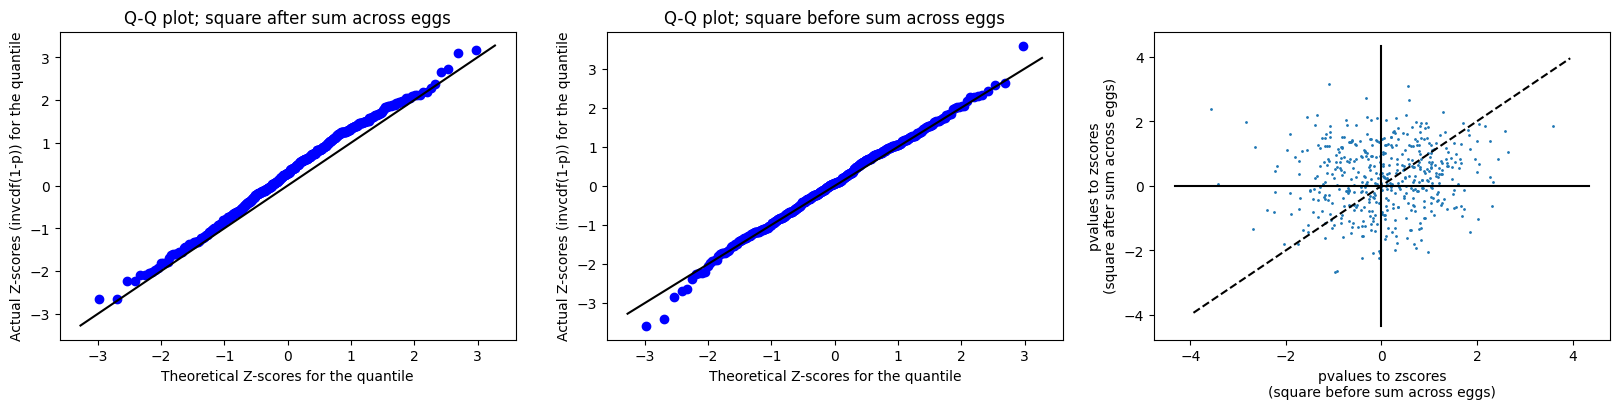

************TIME PERIODS: controltimeshift_-2
Meta-analysis Z-score if squaring *after* summing: 0.19869357573900787 pval: 0.42125122482484567
Meta-analysis Z-score if squaring *before* summing 2.960498531875866 pval:  0.0015357079280670094
Argmax event for square after summing: ('434', '12.12.12 Meditation', datetime.datetime(2012, 12, 12, 12, 30), datetime.datetime(2012, 12, 12, 15, 29, 59), 10800.0) 3.6632892034335143
Argmax event for square before summing: ('106', 'Tiger Woods Triumph', datetime.datetime(2002, 4, 14, 18, 22), datetime.datetime(2002, 4, 14, 22, 59, 59), 16680.0) 3.8126637078267755
Correlation between the two scores: PearsonRResult(statistic=0.12082961322172789, pvalue=0.008385346910044448)


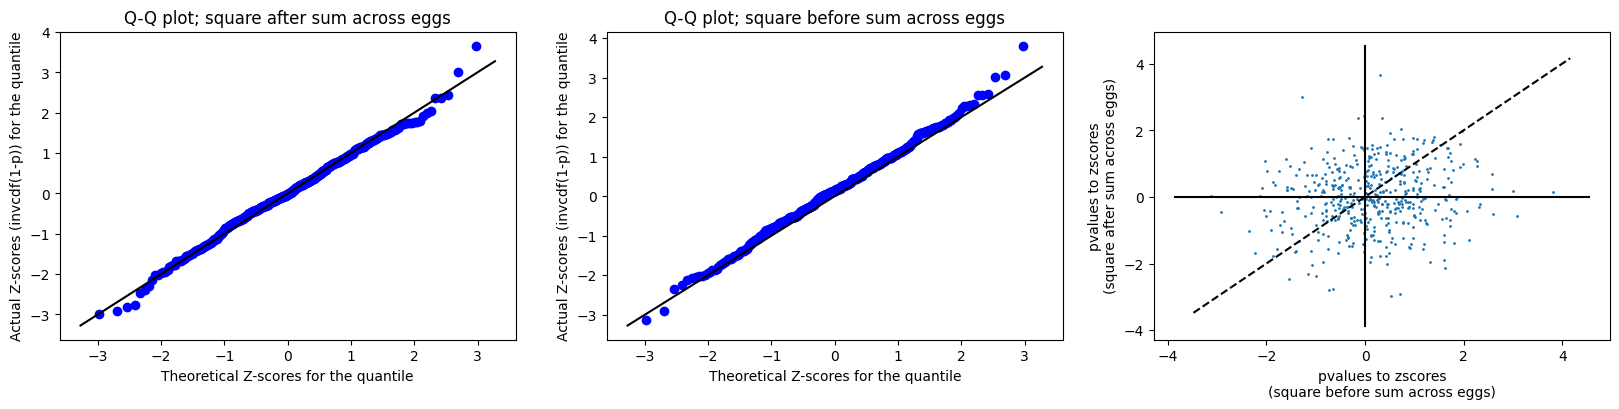

************TIME PERIODS: controltimeshift_2
Meta-analysis Z-score if squaring *after* summing: -0.6335653626348068 pval: 0.7368177441779721
Meta-analysis Z-score if squaring *before* summing -0.15561134071674423 pval:  0.5618303073768627
Argmax event for square after summing: ('376', 'William &amp Catherine', datetime.datetime(2011, 4, 29, 10, 0), datetime.datetime(2011, 4, 29, 15, 59, 59), 21600.0) 3.709429572854
Argmax event for square before summing: ('100', 'Astrid Lindgren Dies', datetime.datetime(2002, 1, 28, 11, 0), datetime.datetime(2002, 1, 28, 14, 59, 59), 14400.0) 3.476080261507864
Correlation between the two scores: PearsonRResult(statistic=0.17346516215733085, pvalue=0.0001450080480884051)


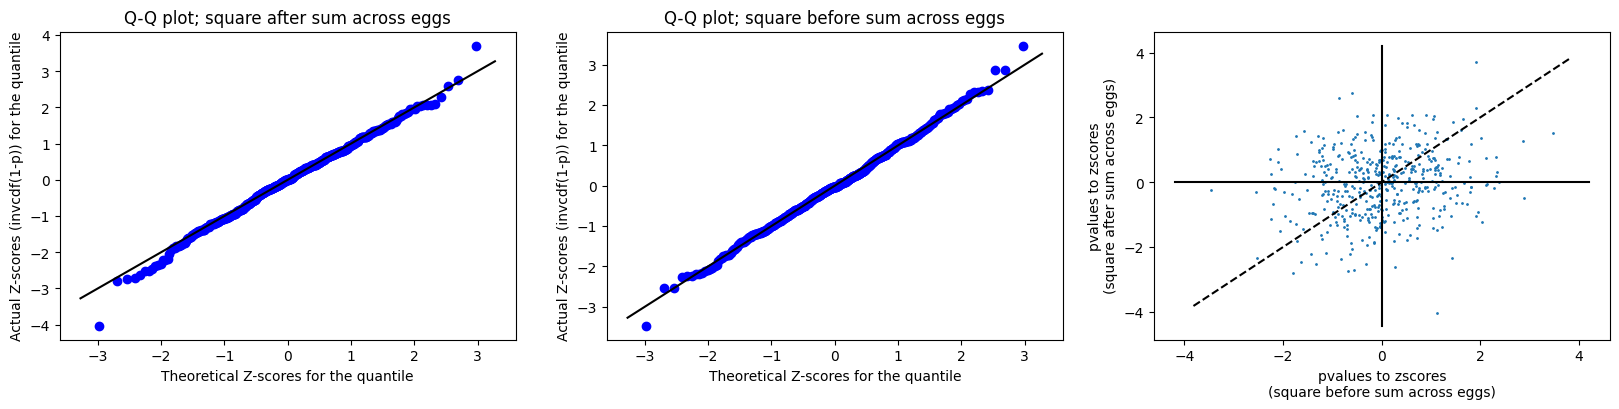

In [10]:
from matplotlib import pyplot as plt

print("num events after dropping events with missing data:", len(surviving_events))

for (touse_pvaltozs_sumthensquare, touse_pvaltozs_squarethensum, testtype) in (
    [ (allevents_pvaltozs_sumthensquare, allevents_pvaltozs_squarethensum, "actual")]
    +[ (controls_pvaltozs_sumthensquare[control_timeshift],
        controls_pvaltozs_squarethensum[control_timeshift],
        "controltimeshift_"+str(control_timeshift))
        for control_timeshift in control_timeshifts ]):

  print("************TIME PERIODS:", testtype)

  pvaltoz_sumthensquare = np.array(touse_pvaltozs_sumthensquare)
  pvaltoz_squarethensum = np.array(touse_pvaltozs_squarethensum)

  metaz_sumthensquare = np.sum(pvaltoz_sumthensquare)/np.sqrt(len(pvaltoz_sumthensquare))
  metaz_squarethensum = np.sum(pvaltoz_squarethensum)/np.sqrt(len(pvaltoz_squarethensum))
  print("Meta-analysis Z-score if squaring *after* summing:", metaz_sumthensquare, "pval:", 1-scipy.stats.norm.cdf(metaz_sumthensquare))
  print("Meta-analysis Z-score if squaring *before* summing", metaz_squarethensum, "pval: ", 1-scipy.stats.norm.cdf(metaz_squarethensum))
  print("Argmax event for square after summing:", surviving_events[np.argmax(pvaltoz_sumthensquare)], np.max(pvaltoz_sumthensquare))
  print("Argmax event for square before summing:", surviving_events[np.argmax(pvaltoz_squarethensum)], np.max(pvaltoz_squarethensum))
  print("Correlation between the two scores:", scipy.stats.pearsonr(pvaltoz_squarethensum, pvaltoz_sumthensquare))

  fig, ax = plt.subplots(ncols=3, figsize=(20,4))
  plt.sca(ax[0])
  scipy.stats.probplot(pvaltoz_sumthensquare, dist=scipy.stats.norm, plot=plt, fit=False)
  plt.plot(plt.xlim(), plt.xlim(), color="black")
  plt.title("Q-Q plot; square after sum across eggs")
  plt.xlabel("Theoretical Z-scores for the quantile")
  plt.ylabel("Actual Z-scores (invcdf(1-p)) for the quantile")
  plt.sca(ax[1])
  scipy.stats.probplot(pvaltoz_squarethensum, dist=scipy.stats.norm, plot=plt, fit=False)
  plt.plot(plt.xlim(), plt.xlim(), color="black")
  plt.title("Q-Q plot; square before sum across eggs")
  plt.xlabel("Theoretical Z-scores for the quantile")
  plt.ylabel("Actual Z-scores (invcdf(1-p)) for the quantile")
  plt.sca(ax[2])
  plt.scatter(pvaltoz_squarethensum, pvaltoz_sumthensquare, s=1)
  plt.plot(plt.xlim(), plt.xlim(), color="black", linestyle="--")
  plt.plot(plt.xlim(), [0,0], color="black")
  plt.plot([0,0], plt.ylim(), color="black")
  plt.xlabel("pvalues to zscores\n(square before sum across eggs)")
  plt.ylabel("pvalues to zscores\n(square after sum across eggs)")
  plt.show()